In [1]:
import sys
sys.path.append('..')

# Load model

In [2]:
# Set the parameters to correspond to the loaded model
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=8, type=int, help="Batch size.")
parser.add_argument("--epochs", default=50, type=int, help="Number of epochs.")
parser.add_argument("--lr", default=1e-4, type=float, help="Learning rate.")
parser.add_argument("--loss_weight", action='store_true', help="Use weighted CE loss (Classes are inbalanced).")
parser.set_defaults(loss_weight=False)
parser.add_argument("--resnet", default='50', type=str, help="Resnet backbone version.")
parser.add_argument("--num_heads", default=2, type=int, help="Number attention heads in CT.")
parser.add_argument("--expl_coeff", default=0.0, type=float, help="Influence of explanation loss (concepts prediction).")
args = parser.parse_args(args=[])

checkpoint_path = '../logs/resnet_apy/2022-12-05_175746-bs=64,e=50,ec=2.0,lw=False,l=0.0001,nh=2,r=50/checkpoint/epoch=18-step=1691.ckpt'

In [3]:
import pytorch_lightning as pl

from ct.data.apy import aPY
from ct.model.ct_resnet_apy import CT_ResNet_aPY

apy = aPY(batch_size=args.batch_size, data_path='../data')
model = CT_ResNet_aPY(args)
model = model.load_from_checkpoint(checkpoint_path, args=args)

trainer = pl.Trainer(accelerator='gpu', devices=1)

/opt/conda/envs/dd2412/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Test model

In [12]:
trainer.test(model=model, datamodule=apy)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8320305943489075     │
│       test_cls_loss       │    1.0162798166275024     │
│      test_expl_loss       │    0.11320725083351135    │
│         test_loss         │    1.0162798166275024     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8320305943489075,
  'test_cls_loss': 1.0162798166275024,
  'test_expl_loss': 0.11320725083351135,
  'test_loss': 1.0162798166275024}]

# Explore predictions

In [18]:
apy = aPY(batch_size=8, data_path='../data')
apy.setup()
id2class = apy.train.dataset.id2class
id2attribute = apy.train.dataset.id2attribute

# Concept threshold
c_th = 1e-1

test = iter(apy.test_dataloader())

In [16]:
batch = next()

pred_out = model.predict_step(batch, None)
image, target_class, target_concept, pred_class, attn = pred_out

target class:  aeroplane
predicted class:  aeroplane
target concepts:  ['Horiz Cyl' 'Wing' 'Propeller' 'Window' 'Wheel' 'Metal' 'Glass']
predicted concepts:  ['Beak' 'Engine']


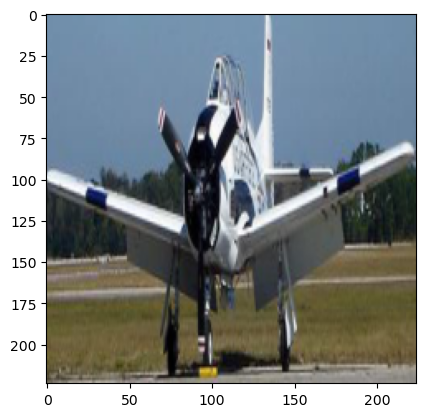

In [25]:
import matplotlib.pyplot as plt

idx = 7
plt.imshow(image[idx].permute(1, 2, 0))
print('target class: ', id2class[target_class[idx]])
print('predicted class: ', id2class[pred_class[idx]])
print('target concepts: ', id2attribute[target_concept[idx] == 1])
print('predicted concepts: ', id2attribute[attn[idx] > c_th])